In [64]:
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch.autograd import Function
from torchvision import datasets, transforms
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

import qiskit
from qiskit import transpile, assemble
from qiskit.visualization import *


import sys
sys.path.append('../Pyfiles')
# Pull in the helper files.
from ImageRead import *

import qiskit
from qiskit import transpile, assemble
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, execute
from qiskit import BasicAer, Aer, execute
from qiskit.quantum_info import state_fidelity
from qiskit.visualization import *
from qiskit.quantum_info.operators import Operator


In [65]:
pathY=r'..\\dataset\\Labels-Binary\\storm\\'
pathN=r'..\\dataset\\Labels-Binary\\No-storm\\'
nameN='no_storm'
nameY='storm'
targetY=[imageResize(callImage(i+1,pathY,nameY),8) for i in range(25)]
targetN=[imageResize(callImage(i+1,pathN,nameN),8) for i in range(25)]
target_combine = targetY+targetN

In [66]:
target_o = [0 for i in range(25)]+[1 for i in range(25)]

In [70]:
pathY=r'..\\dataset\\Original\\storm\\'
pathN=r'..\\dataset\\Original\\No-storm\\'
nameN='no_storm'
nameY='storm'
inputY=[imageResize(callImage(i+1,pathY,nameY),128) for i in range(25)]
inputN=[imageResize(callImage(i+1,pathN,nameN),128) for i in range(25)]
input_combine = inputY+inputN

In [71]:
import random
np.random.seed(0)
idx=np.array([int(i) for i in range(50)]).flatten()

np.random.shuffle(idx)

dataInput = list(input_combine[i] for i in idx )
dataTarget = list( imageBinarize(input_combine[i]) for i in idx )

data_target_o=list( target_o[i] for i in idx )

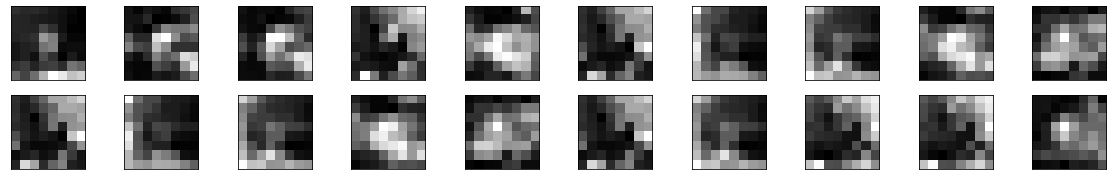

In [69]:
n_samples_show = 10
fig, axes = plt.subplots(nrows=2, ncols=n_samples_show, figsize=(20, 3))

for i in range(10):

    axes[0,i].imshow(dataInput[i], cmap='gray')
    axes[0,i].set_xticks([])
    axes[0,i].set_yticks([])
    axes[1,i].imshow(dataInput[i+5], cmap='gray')
    axes[1,i].set_xticks([])
    axes[1,i].set_yticks([])    


In [72]:

Xtest= [normlaizeData(dataInput[i+15].flatten()) for i in range(10)]
y01test= [data_target_o[i+15] for i in range(10)]

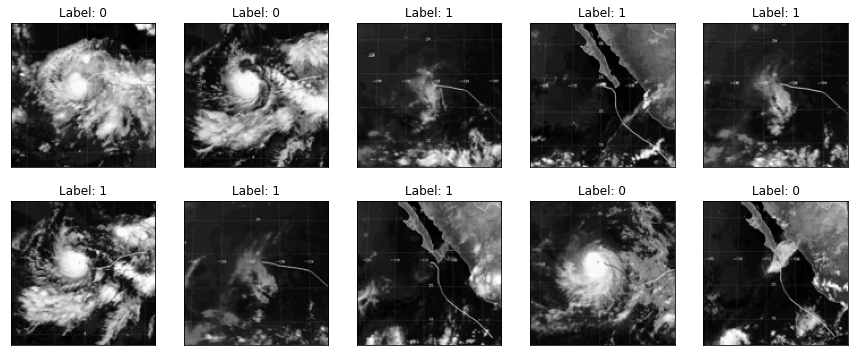

In [75]:
n_samples_show = 5
fig, axes = plt.subplots(nrows=2, ncols=n_samples_show, figsize=(15, 6))

for i in range(5):
    axes[0,i].imshow(np.array(np.array_split(Xtest[i], 128)), cmap='gray')
    axes[0,i].set_xticks([])
    axes[0,i].set_yticks([])
    axes[0,i].set_title("Label: {}".format(y01test[i]))
    axes[1,i].imshow(np.array(np.array_split(Xtest[i+5], 128)), cmap='gray')
    axes[1,i].set_xticks([])
    axes[1,i].set_yticks([])
    axes[1,i].set_title("Label: {}".format(y01test[i+5]))    

In [ ]:
n_samples_show = 5
fig, axes = plt.subplots(nrows=2, ncols=n_samples_show, figsize=(15, 6))

for i in range(5):
    axes[0,i].imshow(np.array(np.array_split(Xtest[i], 128)), cmap='gray')
    axes[0,i].set_xticks([])
    axes[0,i].set_yticks([])
    axes[0,i].set_title("Label: {}".format(y01test[i]))
    axes[1,i].imshow(np.array(np.array_split(Xtest[i+5], 128)), cmap='gray')
    axes[1,i].set_xticks([])
    axes[1,i].set_yticks([])
    axes[1,i].set_title("Label: {}".format(data_target_o[i+5]))    

# Parameterized Quantum Circuit

In [9]:
def normlaizeData(data):
    #Create Array of pixel value
    testdata=data
    arr_data=testdata.flatten()/max(testdata.flatten());
    encoding_data= np.array([np.round(x,6) for x in arr_data]);
    sum_const=np.sqrt(sum(encoding_data*encoding_data))
    encoding_norm=encoding_data/sum_const
    return encoding_norm

In [10]:
# Choose on PQC from Hannah  Sim https://arxiv.org/pdf/1905.10876.pdf circuit 15

def circuit15(qc,theta):
    #circuit 15
    #theta is list of the parameters
    #theta length is (8)L
    #L is the number of repeatation
    nqubits=6
    qr = QuantumRegister(nqubits)
    qc = QuantumCircuit(qr, name='PQC')

    count=0


    for i in range(nqubits):
        qc.ry(theta[count],i)
        count=count+1
    for i in range(nqubits-1):
        qc.cx(i,i+1)
    
    qc.cx(0,nqubits-1)
    for i in range(nqubits):
        qc.ry(theta[count],i)
        count=count+1    
    for i in range(nqubits-1):
        qc.cx(i+1,i)
    qc.cx(nqubits-1,0)
    qc.to_instruction()
    return qc


In [29]:
# Choose on PQC from Hannah  Sim https://arxiv.org/pdf/1905.10876.pdf circuit 15

def encoding(qc,theta,L):
    #circuit 15
    #theta is list of the parameters
    #theta length is (8)L
    #L is the number of repeatation
    nqubits=6
    qr = QuantumRegister(nqubits)
    qc = QuantumCircuit(qr, name='Embed')

    count=0
    for i in range(nqubits):
        qc.h(i)
        
    for l in range(L):
        for i in range(nqubits):
            qc.ry(theta[count],i)
            count=count+1
        for i in range(nqubits-1):
            qc.cx(i,i+1)
        
        qc.cx(nqubits-1,0)
        for i in range(nqubits):
            qc.ry(theta[count],i)
            count=count+1    
        for i in range(nqubits-1):
            qc.cx(i+1,i)
        qc.cx(0,nqubits-1)
        
    qc.to_instruction()
    return qc

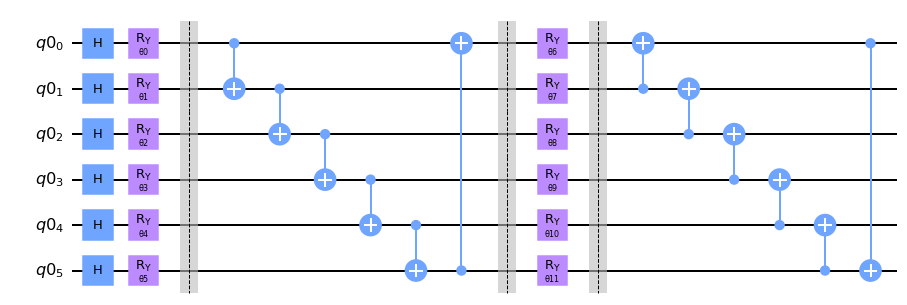

In [12]:

from qiskit.circuit import Parameter

nqubits=6
qr = QuantumRegister(nqubits)
qc = QuantumCircuit(qr, name='PQC')
param_y=[];
for i in range(nqubits*2):
    param_y.append((Parameter('θ'+str(i))))

count=0
for i in range(nqubits):
    qc.h(i)
        
for i in range(nqubits):
    qc.ry(param_y[count],i)
    count=count+1
qc.barrier()    
for i in range(nqubits-1):
    qc.cx(i,i+1)

qc.cx(nqubits-1,0)
qc.barrier()   
for i in range(nqubits):
    qc.ry(param_y[count],i)
    count=count+1    
qc.barrier()       
for i in range(nqubits-1):
    qc.cx(i+1,i)
qc.cx(0,nqubits-1)
qc.draw(output='mpl')


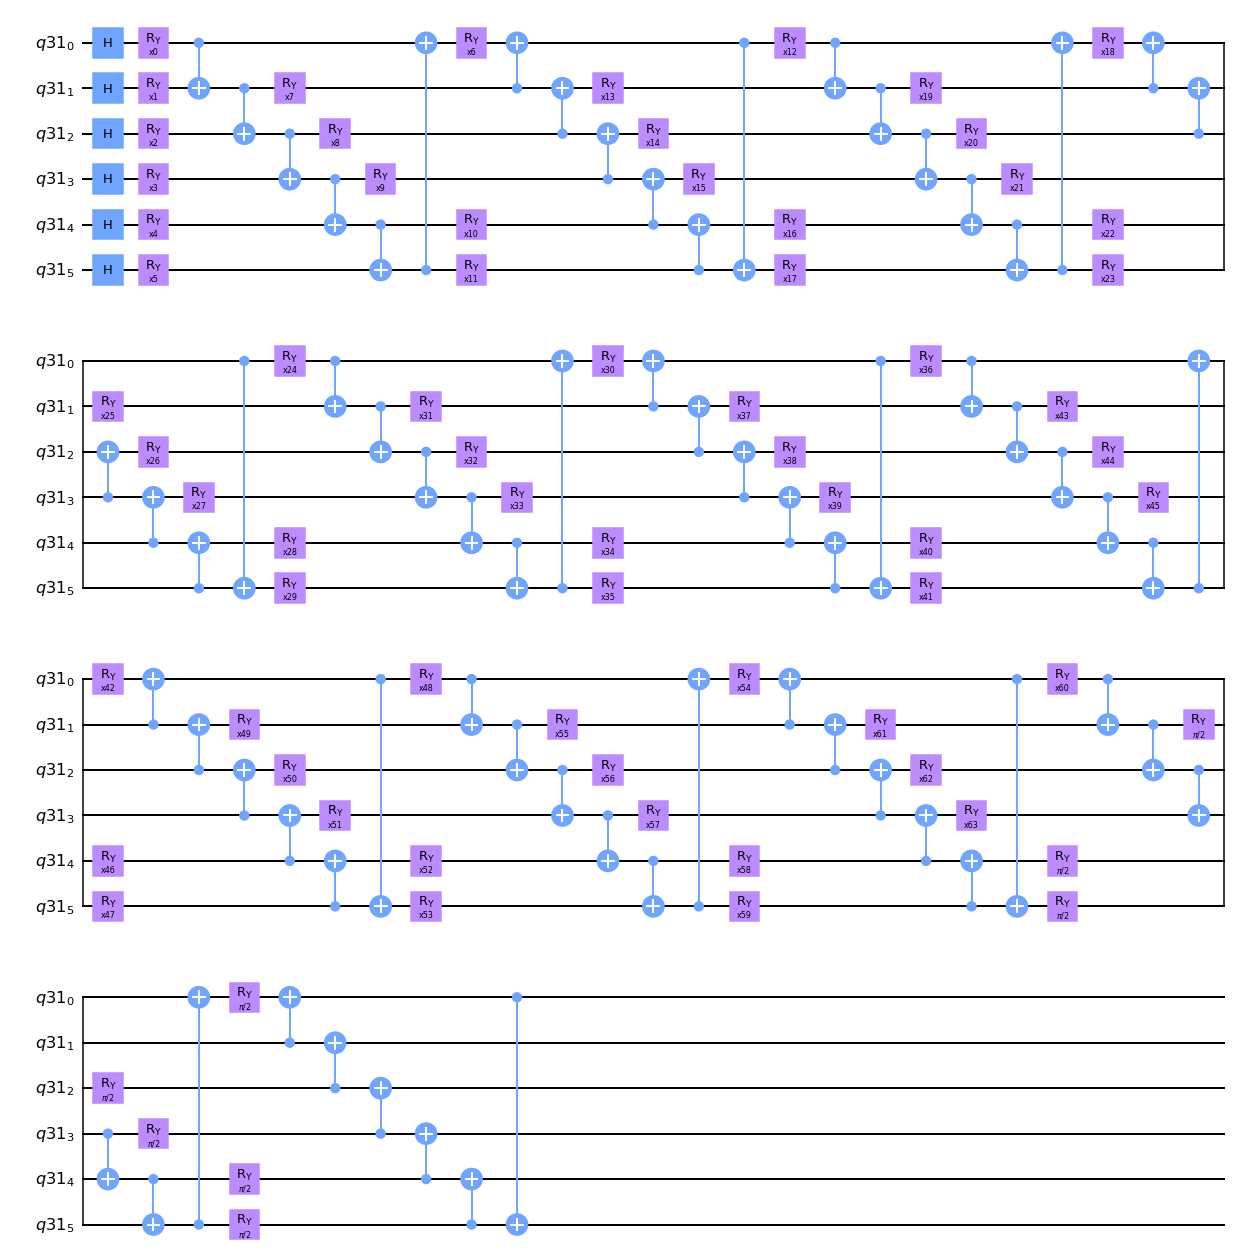

In [35]:
nqubits=6
qr = QuantumRegister(nqubits,'q')
cr = ClassicalRegister(nqubits,'c')


my_circuit = QuantumCircuit(qr,cr)

theta=[];
for i in range(2**nqubits):
    theta.append(Parameter('x'+str(i)))
for i in range(8):
    theta.append(np.pi/2)
qr = QuantumRegister(nqubits)
qc = QuantumCircuit(qr, name='Embed')

count=0
for i in range(nqubits):
    qc.h(i)
    
for l in range(6):
    for i in range(nqubits):
        qc.ry(theta[count],i)
        count=count+1
    for i in range(nqubits-1):
        qc.cx(i,i+1)
    
    qc.cx(nqubits-1,0)
    for i in range(nqubits):
        qc.ry(theta[count],i)
        count=count+1    
    for i in range(nqubits-1):
        qc.cx(i+1,i)
    qc.cx(0,nqubits-1)
qc.draw(output='mpl')

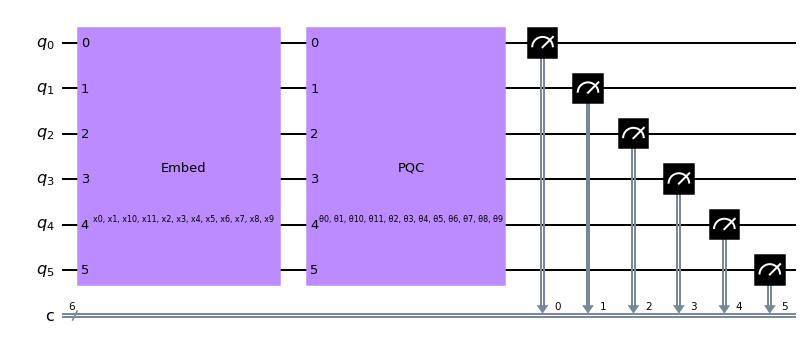

In [26]:
nqubits=6
qr = QuantumRegister(nqubits,'q')
cr = ClassicalRegister(nqubits,'c')

param_y=[];
for i in range(nqubits*2):
    param_y.append((Parameter('θ'+str(i))))

my_circuit = QuantumCircuit(qr,cr)

param_x=[];
for i in range(2**nqubits):
    param_x.append(Parameter('x'+str(i)))
for i in range(8):
    param_x.append(np.pi/2)

my_circuit.append(encoding(dataInput[0],param_x[0:12],1), range(nqubits))
my_circuit.append(circuit15(qr,param_y),range(nqubits))

my_circuit.measure(qr[:],cr[:])
my_circuit.draw(output='mpl')

In [55]:
# mapping the data
# mapping is taken from https://arxiv.org/pdf/2003.09887.pdf
def binary(x):
    return ('0'*(6-len('{:b}'.format(x, '#010b') ))+'{:b}'.format(x, '#010b'))
def firsttwo(x):
    return x[:2]
parity = lambda x: firsttwo(binary(x)).count('1') % 2

In [63]:
binary(17)

'010001'

# Good Result

In [38]:
from qiskit_machine_learning.neural_networks import CircuitQNN
from qiskit_machine_learning.connectors import TorchConnector
from qiskit.utils import QuantumInstance
from torch.nn import Linear, CrossEntropyLoss, MSELoss
from torch.optim import LBFGS, SGD,Adam 
qi = QuantumInstance(Aer.get_backend('statevector_simulator'))
from qiskit.circuit.library import RealAmplitudes, ZZFeatureMap
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier, VQC
from qiskit.algorithms.optimizers import COBYLA, L_BFGS_B

# Model for LBFGS
# Combining the circuit together with CircuitQNN
np.random.seed(3)


nqubits=6
num_inputs=2**nqubits
qc = QuantumCircuit(nqubits)

param_x=[];
for i in range(2**nqubits):
    param_x.append(Parameter('x'+str(i)))
for i in range(8):
    param_x.append(np.pi/2)

feature_map = encoding(qr,param_x,6)

param_y=[];
for i in range(nqubits*2):
    param_y.append(Parameter('θ'+str(i)))

ansatz=circuit15(qr,param_y)

qc.append(feature_map, range(nqubits))
qc.append(ansatz, range(nqubits))

qnn2 = CircuitQNN(qc, input_params=feature_map.parameters, weight_params=ansatz.parameters, 
                  interpret=parity, output_shape=2, quantum_instance=qi)
initial_weights = 0.1*(2*np.random.rand(qnn2.num_weights) - 1)


In [39]:
# define optimizer and loss function

model2 = TorchConnector(qnn2, initial_weights)

optimizer = LBFGS(model2.parameters(),lr=0.1)
f_loss = CrossEntropyLoss()

X= [normlaizeData(dataInput[i].flatten()) for i in range(15)]
y01= [data_target_o[i] for i in range(15)]

In [40]:
from torch import Tensor
# start training

model2.train()    # set model to training mode

# define objective function
def closure():
    optimizer.zero_grad()                                  # initialize gradient
    loss = 0.0                                             # initialize loss    
    for x, y_target in zip(X, y01):                        # evaluate batch loss
        output = model2(Tensor(x)).reshape(1, 2)           # forward pass
        loss += f_loss(output, Tensor([y_target]).long())
    loss.backward()                                        # backward pass
    print(loss.item())                                     # print loss
    return loss

# run optimizer
optimizer.step(closure)

10.976895332336426
10.95108413696289
10.92065143585205
10.88494873046875
10.843300819396973
10.795140266418457
10.740145683288574
10.678409576416016
10.610583305358887
10.537991523742676
10.462610244750977
10.386885643005371
9.922740936279297
9.913456916809082
9.903972625732422
9.89436149597168
9.884696960449219
10.193254470825195
10.285778045654297
10.189127922058105


tensor(10.9769, grad_fn=<AddBackward0>)

In [41]:
# traning model accuracy
y_predict = []
for x in X:
    output = model2(Tensor(x))
    y_predict += [np.argmax(output.detach().numpy())]

print('Accuracy:', sum(y_predict == np.array(y01))/len(np.array(y01)))

Accuracy: 0.8666666666666667


In [42]:
# Test nidek accuracy

Xtest= [normlaizeData(dataInput[i+15].flatten()) for i in range(10)]
y01test= [data_target_o[i+15] for i in range(10)]

y_predict = []
for x in Xtest:
    output = model2(Tensor(x))
    y_predict += [np.argmax(output.detach().numpy())]

print('Accuracy:', sum(y_predict == np.array(y01test))/len(np.array(y01test)))

Accuracy: 0.9


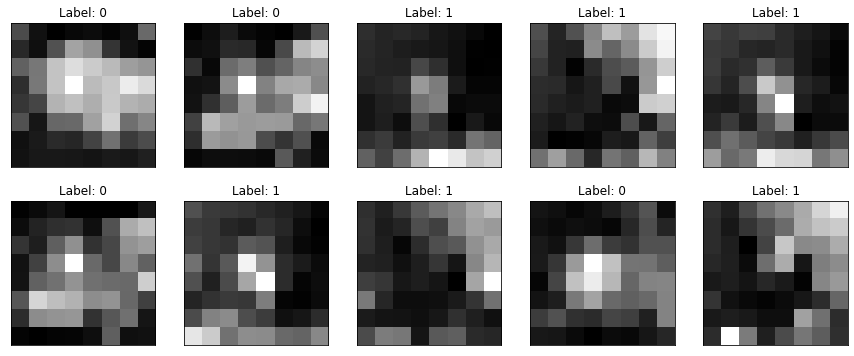

In [49]:
n_samples_show = 5
fig, axes = plt.subplots(nrows=2, ncols=n_samples_show, figsize=(15, 6))

for i in range(5):
    axes[0,i].imshow(np.array(np.array_split(Xtest[i], 8)), cmap='gray')
    axes[0,i].set_xticks([])
    axes[0,i].set_yticks([])
    axes[0,i].set_title("Label: {}".format(y01test[i]))
    axes[1,i].imshow(np.array(np.array_split(Xtest[i+5], 8)), cmap='gray')
    axes[1,i].set_xticks([])
    axes[1,i].set_yticks([])
    axes[1,i].set_title("Label: {}".format(y01test[i+5]))    

# I could not do amplitude encoding, so I encode other way

In [191]:
from qiskit_machine_learning.neural_networks import CircuitQNN
from qiskit_machine_learning.connectors import TorchConnector
from qiskit.utils import QuantumInstance
from torch.nn import Linear, CrossEntropyLoss, MSELoss
from torch.optim import LBFGS, SGD,Adam 
qi = QuantumInstance(Aer.get_backend('statevector_simulator'))
from qiskit.circuit.library import RealAmplitudes, ZZFeatureMap
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier, VQC
from qiskit.algorithms.optimizers import COBYLA, L_BFGS_B

# Model for LBFGS
# Combining the circuit together with CircuitQNN
np.random.seed(3)


nqubits=6
num_inputs=2**nqubits
qc = QuantumCircuit(nqubits)

param_x=[];
for i in range(2**nqubits):
    param_x.append(Parameter('x'+str(i)))
for i in range(8):
    param_x.append(np.pi/2)

feature_map = encoding(qr,param_x,6)

param_y=[];
for i in range(nqubits*2):
    param_y.append(Parameter('θ'+str(i)))

ansatz=circuit15(qr,param_y)

qc.append(feature_map, range(nqubits))
qc.append(ansatz, range(nqubits))

qnn2 = CircuitQNN(qc, input_params=feature_map.parameters, weight_params=ansatz.parameters, 
                  interpret=parity, output_shape=2, quantum_instance=qi)
initial_weights = 0.1*(2*np.random.rand(qnn2.num_weights) - 1)


# Learning Rate 0.1

In [229]:
# define optimizer and loss function

model2 = TorchConnector(qnn2, initial_weights)

optimizer = LBFGS(model2.parameters(),lr=0.1)
f_loss = CrossEntropyLoss()

X= [normlaizeData(dataInput[i].flatten()) for i in range(15)]
y01= [data_target_o[i] for i in range(15)]

In [201]:
from torch import Tensor
# start training

model2.train()    # set model to training mode

# define objective function
def closure():
    optimizer.zero_grad()                                  # initialize gradient
    loss = 0.0                                             # initialize loss    
    for x, y_target in zip(X, y01):                        # evaluate batch loss
        output = model2(Tensor(x)).reshape(1, 2)           # forward pass
        loss += f_loss(output, Tensor([y_target]).long())
    loss.backward()                                        # backward pass
    print(loss.item())                                     # print loss
    return loss

# run optimizer
optimizer.step(closure)

10.976895332336426
10.95108413696289
10.92065143585205
10.88494873046875
10.843300819396973
10.795140266418457
10.740145683288574
10.678409576416016
10.610583305358887
10.537991523742676
10.462610244750977
10.386885643005371
9.922740936279297
9.913456916809082
9.903972625732422
9.89436149597168
9.884696960449219
10.193254470825195
10.285778045654297
10.189127922058105


tensor(10.9769, grad_fn=<AddBackward0>)

In [202]:
# traning model accuracy
y_predict = []
for x in X:
    output = model2(Tensor(x))
    y_predict += [np.argmax(output.detach().numpy())]

print('Accuracy:', sum(y_predict == np.array(y01))/len(np.array(y01)))

Accuracy: 0.8666666666666667


In [203]:
# Test nidek accuracy

Xtest= [normlaizeData(dataInput[i+15].flatten()) for i in range(10)]
y01test= [data_target_o[i+15] for i in range(10)]

y_predict = []
for x in Xtest:
    output = model2(Tensor(x))
    y_predict += [np.argmax(output.detach().numpy())]

print('Accuracy:', sum(y_predict == np.array(y01test))/len(np.array(y01test)))

Accuracy: 0.9


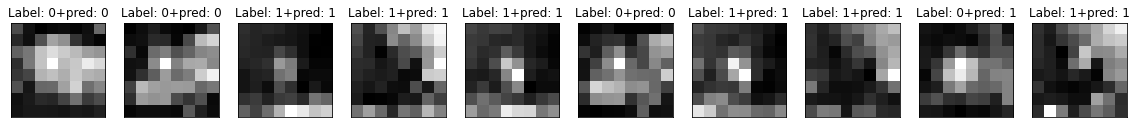

In [204]:
n_samples_show = 10
fig, axes = plt.subplots(nrows=1, ncols=n_samples_show, figsize=(20, 3))

for i in range(10):
    axes[i].imshow(np.array(np.array_split(Xtest[i], 8)), cmap='gray')
    axes[i].set_xticks([])
    axes[i].set_yticks([])
    axes[i].set_title("Label: {}".format(y01test[i])+"+pred: {}".format(y_predict[i]))

# Learning Rate 0.05

In [205]:
# define optimizer and loss function

model2 = TorchConnector(qnn2, initial_weights)

optimizer = LBFGS(model2.parameters(),lr=0.05)
f_loss = CrossEntropyLoss()

X= [normlaizeData(dataInput[i].flatten()) for i in range(15)]
y01= [data_target_o[i] for i in range(15)]

In [206]:
from torch import Tensor
# start training

model2.train()    # set model to training mode

# define objective function
def closure():
    optimizer.zero_grad()                                  # initialize gradient
    loss = 0.0                                             # initialize loss    
    for x, y_target in zip(X, y01):                        # evaluate batch loss
        output = model2(Tensor(x)).reshape(1, 2)           # forward pass
        loss += f_loss(output, Tensor([y_target]).long())
    loss.backward()                                        # backward pass
    print(loss.item())                                     # print loss
    return loss

# run optimizer
optimizer.step(closure)

10.976895332336426
10.964250564575195
10.950470924377441
10.935493469238281
10.919225692749023
10.901573181152344
10.88244915008545
10.861762046813965
10.839436531066895
10.815408706665039
10.78963565826416
10.762092590332031
10.73279094696045
10.701778411865234
10.669137954711914
10.63499641418457
10.59953498840332
10.562968254089355
10.525558471679688
10.487597465515137


tensor(10.9769, grad_fn=<AddBackward0>)

In [207]:
# traning model accuracy
y_predict = []
for x in X:
    output = model2(Tensor(x))
    y_predict += [np.argmax(output.detach().numpy())]

print('Accuracy:', sum(y_predict == np.array(y01))/len(np.array(y01)))

Accuracy: 0.6


In [208]:
# Test nidek accuracy

Xtest= [normlaizeData(dataInput[i+15].flatten()) for i in range(10)]
y01test= [data_target_o[i+15] for i in range(10)]

y_predict = []
for x in Xtest:
    output = model2(Tensor(x))
    y_predict += [np.argmax(output.detach().numpy())]

print('Accuracy:', sum(y_predict == np.array(y01test))/len(np.array(y01test)))

Accuracy: 0.6


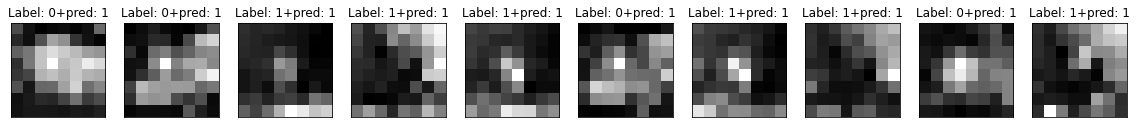

In [209]:
n_samples_show = 10
fig, axes = plt.subplots(nrows=1, ncols=n_samples_show, figsize=(20, 3))

for i in range(10):
    axes[i].imshow(np.array(np.array_split(Xtest[i], 8)), cmap='gray')
    axes[i].set_xticks([])
    axes[i].set_yticks([])
    axes[i].set_title("Label: {}".format(y01test[i])+"+pred: {}".format(y_predict[i]))

# Learning rate 0.01

In [210]:
# define optimizer and loss function

model2 = TorchConnector(qnn2, initial_weights)

optimizer = LBFGS(model2.parameters(),lr=0.01)
f_loss = CrossEntropyLoss()

X= [normlaizeData(dataInput[i].flatten()) for i in range(15)]
y01= [data_target_o[i] for i in range(15)]

In [211]:
from torch import Tensor
# start training

model2.train()    # set model to training mode

# define objective function
def closure():
    optimizer.zero_grad()                                  # initialize gradient
    loss = 0.0                                             # initialize loss    
    for x, y_target in zip(X, y01):                        # evaluate batch loss
        output = model2(Tensor(x)).reshape(1, 2)           # forward pass
        loss += f_loss(output, Tensor([y_target]).long())
    loss.backward()                                        # backward pass
    print(loss.item())                                     # print loss
    return loss

# run optimizer
optimizer.step(closure)

10.976895332336426
10.974409103393555
10.97187328338623
10.969293594360352
10.966669082641602
10.96399974822998
10.961284637451172
10.958521842956543
10.955713272094727
10.952855110168457
10.949950218200684
10.946993827819824
10.943984985351562
10.940926551818848
10.937816619873047
10.934653282165527
10.931434631347656
10.928163528442383
10.924835205078125
10.921452522277832


tensor(10.9769, grad_fn=<AddBackward0>)

In [212]:
# traning model accuracy
y_predict = []
for x in X:
    output = model2(Tensor(x))
    y_predict += [np.argmax(output.detach().numpy())]

print('Accuracy:', sum(y_predict == np.array(y01))/len(np.array(y01)))

Accuracy: 0.6


In [213]:
# Test nidek accuracy

Xtest= [normlaizeData(dataInput[i+15].flatten()) for i in range(10)]
y01test= [data_target_o[i+15] for i in range(10)]

y_predict = []
for x in Xtest:
    output = model2(Tensor(x))
    y_predict += [np.argmax(output.detach().numpy())]

print('Accuracy:', sum(y_predict == np.array(y01test))/len(np.array(y01test)))

Accuracy: 0.6


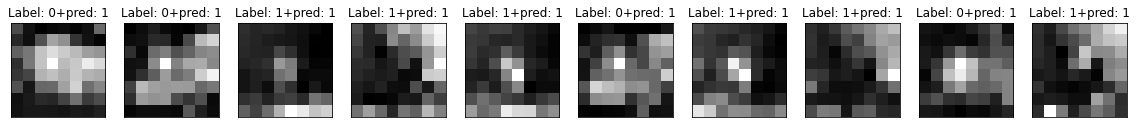

In [214]:
n_samples_show = 10
fig, axes = plt.subplots(nrows=1, ncols=n_samples_show, figsize=(20, 3))

for i in range(10):
    axes[i].imshow(np.array(np.array_split(Xtest[i], 8)), cmap='gray')
    axes[i].set_xticks([])
    axes[i].set_yticks([])
    axes[i].set_title("Label: {}".format(y01test[i])+"+pred: {}".format(y_predict[i]))

# Learning Rate 0.5

In [215]:
# define optimizer and loss function

model2 = TorchConnector(qnn2, initial_weights)

optimizer = LBFGS(model2.parameters(),lr=0.5)
f_loss = CrossEntropyLoss()

X= [normlaizeData(dataInput[i].flatten()) for i in range(15)]
y01= [data_target_o[i] for i in range(15)]

In [216]:
from torch import Tensor
# start training

model2.train()    # set model to training mode

# define objective function
def closure():
    optimizer.zero_grad()                                  # initialize gradient
    loss = 0.0                                             # initialize loss    
    for x, y_target in zip(X, y01):                        # evaluate batch loss
        output = model2(Tensor(x)).reshape(1, 2)           # forward pass
        loss += f_loss(output, Tensor([y_target]).long())
    loss.backward()                                        # backward pass
    print(loss.item())                                     # print loss
    return loss

# run optimizer
optimizer.step(closure)

10.976895332336426
10.82863712310791
10.557868003845215
10.20727825164795
10.051664352416992
10.012788772583008
10.004587173461914
9.99907112121582
9.985710144042969
9.990602493286133
9.951266288757324
10.030051231384277
9.968423843383789
9.869895935058594
9.84715747833252
9.797903060913086
9.703434944152832
9.625359535217285
9.462546348571777
9.404194831848145


tensor(10.9769, grad_fn=<AddBackward0>)

In [217]:
# Test nidek accuracy

Xtest= [normlaizeData(dataInput[i+15].flatten()) for i in range(10)]
y01test= [data_target_o[i+15] for i in range(10)]

y_predict = []
for x in Xtest:
    output = model2(Tensor(x))
    y_predict += [np.argmax(output.detach().numpy())]

print('Accuracy:', sum(y_predict == np.array(y01test))/len(np.array(y01test)))

Accuracy: 0.6


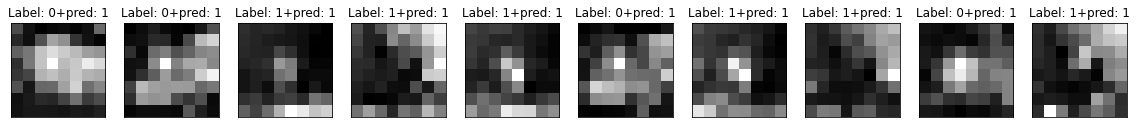

In [218]:
n_samples_show = 10
fig, axes = plt.subplots(nrows=1, ncols=n_samples_show, figsize=(20, 3))

for i in range(10):
    axes[i].imshow(np.array(np.array_split(Xtest[i], 8)), cmap='gray')
    axes[i].set_xticks([])
    axes[i].set_yticks([])
    axes[i].set_title("Label: {}".format(y01test[i])+"+pred: {}".format(y_predict[i]))

# LEarning rate 1

In [219]:
# define optimizer and loss function

model2 = TorchConnector(qnn2, initial_weights)

optimizer = LBFGS(model2.parameters(),lr=1)
f_loss = CrossEntropyLoss()

X= [normlaizeData(dataInput[i].flatten()) for i in range(15)]
y01= [data_target_o[i] for i in range(15)]

In [220]:
from torch import Tensor
# start training

model2.train()    # set model to training mode

# define objective function
def closure():
    optimizer.zero_grad()                                  # initialize gradient
    loss = 0.0                                             # initialize loss    
    for x, y_target in zip(X, y01):                        # evaluate batch loss
        output = model2(Tensor(x)).reshape(1, 2)           # forward pass
        loss += f_loss(output, Tensor([y_target]).long())
    loss.backward()                                        # backward pass
    print(loss.item())                                     # print loss
    return loss

# run optimizer
optimizer.step(closure)

10.976895332336426
10.643277168273926
10.042010307312012
10.044075965881348
10.016291618347168
10.006301879882812
10.002432823181152
9.987083435058594
9.907049179077148
9.756710052490234
9.609301567077637
9.588217735290527
9.532124519348145
9.475543022155762
9.516643524169922
9.418832778930664
9.348185539245605
9.27226734161377
9.91568374633789
9.216962814331055


tensor(10.9769, grad_fn=<AddBackward0>)

In [221]:
# Test nidek accuracy

Xtest= [normlaizeData(dataInput[i+15].flatten()) for i in range(10)]
y01test= [data_target_o[i+15] for i in range(10)]

y_predict = []
for x in Xtest:
    output = model2(Tensor(x))
    y_predict += [np.argmax(output.detach().numpy())]

print('Accuracy:', sum(y_predict == np.array(y01test))/len(np.array(y01test)))

Accuracy: 0.6


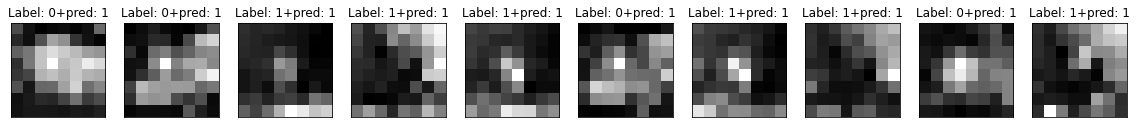

In [222]:
n_samples_show = 10
fig, axes = plt.subplots(nrows=1, ncols=n_samples_show, figsize=(20, 3))

for i in range(10):
    axes[i].imshow(np.array(np.array_split(Xtest[i], 8)), cmap='gray')
    axes[i].set_xticks([])
    axes[i].set_yticks([])
    axes[i].set_title("Label: {}".format(y01test[i])+"+pred: {}".format(y_predict[i]))

# Adam Optimizer

In [223]:
model3 = TorchConnector(qnn2, initial_weights)

optimizer = optim.Adam(model3.parameters(),lr=0.05)
f_loss = MSELoss(reduction='mean')

X= [normlaizeData(dataInput[i].flatten()) for i in range(15)]
y01= [data_target_o[i] for i in range(15)]

model3.train()   
epochs = 10     # set number of epochs

for epoch in range(epochs):
    optimizer.zero_grad()                                  
    loss = 0.0                                               
    for x, y_target in zip(X, y01):                        
        output = model3(Tensor(x)).reshape(1, 2)           
        targets=Tensor([y_target]).long()
        targets = targets.to(torch.float32)
        loss += f_loss(output, targets) 
    loss.backward()                                        
    print(loss.item())                                   

    optimizer.step()

4.0493268966674805
4.00144100189209
3.9602036476135254
3.9227709770202637
3.8880081176757812
3.8563950061798096
3.828550100326538
3.80505633354187
3.786421775817871
3.7730185985565186


Accuracy: 0.6


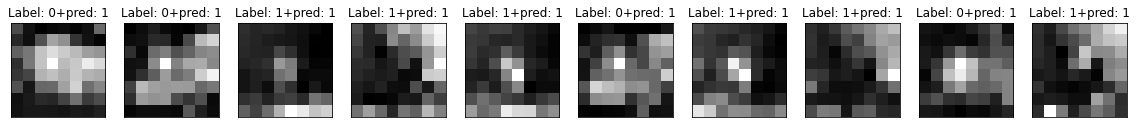

In [224]:
# Test nidek accuracy

Xtest= [normlaizeData(dataInput[i+15].flatten()) for i in range(10)]
y01test= [data_target_o[i+15] for i in range(10)]

y_predict = []
for x in Xtest:
    output = model2(Tensor(x))
    y_predict += [np.argmax(output.detach().numpy())]

print('Accuracy:', sum(y_predict == np.array(y01test))/len(np.array(y01test)))
n_samples_show = 10
fig, axes = plt.subplots(nrows=1, ncols=n_samples_show, figsize=(20, 3))

for i in range(10):
    axes[i].imshow(np.array(np.array_split(Xtest[i], 8)), cmap='gray')
    axes[i].set_xticks([])
    axes[i].set_yticks([])
    axes[i].set_title("Label: {}".format(y01test[i])+"+pred: {}".format(y_predict[i]))

In [225]:
model3 = TorchConnector(qnn2, initial_weights)

optimizer = optim.Adam(model3.parameters(),lr=0.5)
f_loss = MSELoss(reduction='mean')

X= [normlaizeData(dataInput[i].flatten()) for i in range(15)]
y01= [data_target_o[i] for i in range(15)]

model3.train()   
epochs = 10     # set number of epochs

for epoch in range(epochs):
    optimizer.zero_grad()                                  
    loss = 0.0                                               
    for x, y_target in zip(X, y01):                        
        output = model3(Tensor(x)).reshape(1, 2)           
        targets=Tensor([y_target]).long()
        targets = targets.to(torch.float32)
        loss += f_loss(output, targets) 
    loss.backward()                                        
    print(loss.item())                                   

    optimizer.step()

4.0493268966674805
3.920520544052124
3.7835545539855957
3.771392822265625
3.7681045532226562
3.7557644844055176
3.762380838394165
3.7734103202819824
3.7688097953796387
3.7634429931640625


Accuracy: 0.6


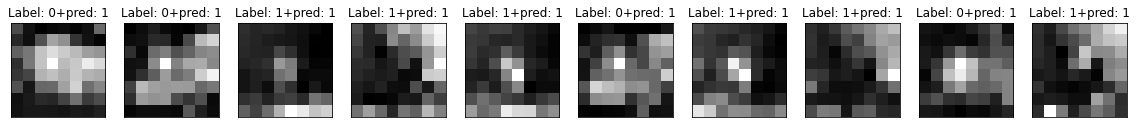

In [226]:
# Test nidek accuracy

Xtest= [normlaizeData(dataInput[i+15].flatten()) for i in range(10)]
y01test= [data_target_o[i+15] for i in range(10)]

y_predict = []
for x in Xtest:
    output = model2(Tensor(x))
    y_predict += [np.argmax(output.detach().numpy())]

print('Accuracy:', sum(y_predict == np.array(y01test))/len(np.array(y01test)))
n_samples_show = 10
fig, axes = plt.subplots(nrows=1, ncols=n_samples_show, figsize=(20, 3))

for i in range(10):
    axes[i].imshow(np.array(np.array_split(Xtest[i], 8)), cmap='gray')
    axes[i].set_xticks([])
    axes[i].set_yticks([])
    axes[i].set_title("Label: {}".format(y01test[i])+"+pred: {}".format(y_predict[i]))

In [227]:
model3 = TorchConnector(qnn2, initial_weights)

optimizer = optim.Adam(model3.parameters(),lr=1)
f_loss = MSELoss(reduction='mean')

X= [normlaizeData(dataInput[i].flatten()) for i in range(15)]
y01= [data_target_o[i] for i in range(15)]

model3.train()   
epochs = 10     # set number of epochs

for epoch in range(epochs):
    optimizer.zero_grad()                                  
    loss = 0.0                                               
    for x, y_target in zip(X, y01):                        
        output = model3(Tensor(x)).reshape(1, 2)           
        targets=Tensor([y_target]).long()
        targets = targets.to(torch.float32)
        loss += f_loss(output, targets) 
    loss.backward()                                        
    print(loss.item())                                   

    optimizer.step()

4.0493268966674805
3.935563802719116
3.7765185832977295
4.030527114868164
3.7564754486083984
3.827744960784912
3.7647969722747803
3.756963014602661
3.777543306350708
3.817495107650757


Accuracy: 0.6


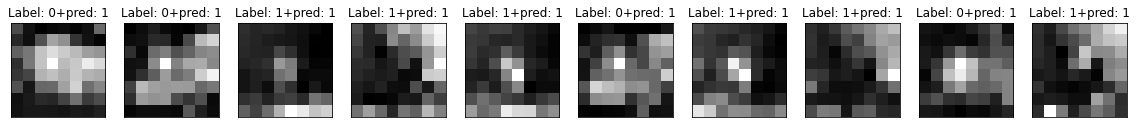

In [228]:
# Test nidek accuracy

Xtest= [normlaizeData(dataInput[i+15].flatten()) for i in range(10)]
y01test= [data_target_o[i+15] for i in range(10)]

y_predict = []
for x in Xtest:
    output = model2(Tensor(x))
    y_predict += [np.argmax(output.detach().numpy())]

print('Accuracy:', sum(y_predict == np.array(y01test))/len(np.array(y01test)))
n_samples_show = 10
fig, axes = plt.subplots(nrows=1, ncols=n_samples_show, figsize=(20, 3))

for i in range(10):
    axes[i].imshow(np.array(np.array_split(Xtest[i], 8)), cmap='gray')
    axes[i].set_xticks([])
    axes[i].set_yticks([])
    axes[i].set_title("Label: {}".format(y01test[i])+"+pred: {}".format(y_predict[i]))